## Using submodel loss of active materials in PyBaMM
In this notebook we show how to use the loss of active materials (LAM) submodel in pybamm. The LAM model follows the equation (25) from [[6]](#References), and the stresses are calculated by equations (7)-(9) in [[1]](#References). To see all of the models and submodels available in PyBaMM, please take a look at the documentation here.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')
# Here the model is applicable to SPM, SPMe and DFN
model = pybamm.lithium_ion.DFN(
    options=
    {
        "particle": "Fickian diffusion", 
        "SEI":"solvent-diffusion limited", 
        "SEI film resistance":"distributed", 
        "SEI porosity change":"false", 
        "particle mechanics":"swelling only",
        "loss of active material":"stress-driven",
    }
)
param = pybamm.ParameterValues("Ai2020")
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-4/3600})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-4/3600})
total_cycles = 2
experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 3 V",
        "Rest for 600 seconds",
        "Charge at 1C until 4.2 V",
        "Hold at 4.199 V for 600 seconds",
    ] * total_cycles
)
sim1 = pybamm.Simulation(
    model, 
    experiment = experiment,
    parameter_values = param,
    solver = pybamm.CasadiSolver("fast with events")
)
solution = sim1.solve(calc_esoh=False)

Note: you may need to restart the kernel to use updated packages.


In [2]:
t_all = solution["Time [h]"].entries
v_all = solution["Voltage [V]"].entries
I_if_n = solution["Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_p = solution["Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]"].entries

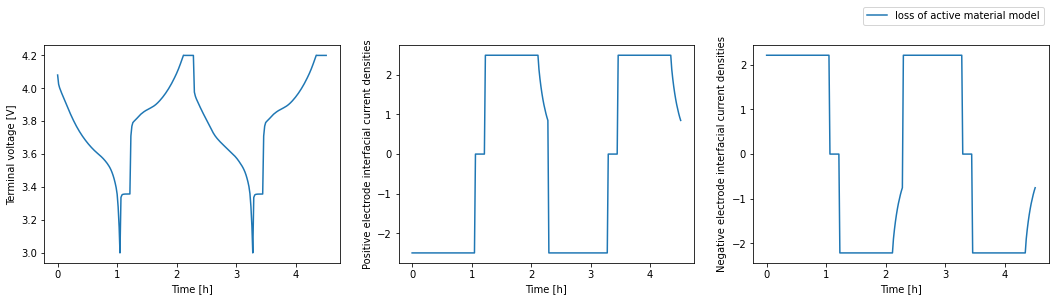

In [3]:

# ploting the results
f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(18,4))

ax1.plot(t_all, v_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Voltage [V]")
#ax1.legend()


ax2.plot(t_all, I_if_p, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Positive electrode interfacial current densities [A.m-3]")
#ax2.legend()
#ax2.set_xlim(6000,7000)

ax3.plot(t_all, I_if_n, label="loss of active material model")
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Negative electrode interfacial current densities [A.m-3]")
ax3.legend(bbox_to_anchor=(1, 1.2))
#ax3.set_xlim(10000,15000)
# f.tight_layout(pad=1.0)
plt.show()

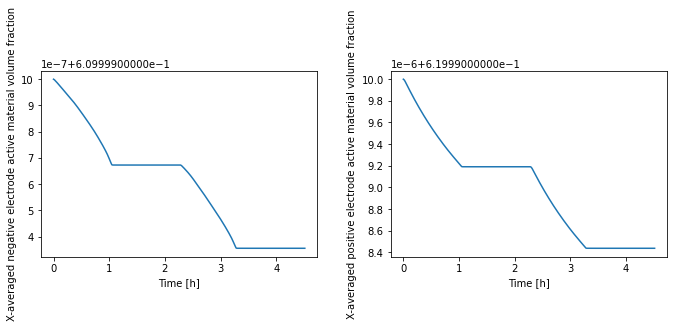

In [4]:
LAM_n_all = solution["X-averaged negative electrode active material volume fraction"].entries
LAM_p_all = solution["X-averaged positive electrode active material volume fraction"].entries
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, LAM_n_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative electrode active material volume fraction")

ax2.plot(t_all, LAM_p_all, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive electrode active material volume fraction")
f.tight_layout(pad=3.0)
plt.show()

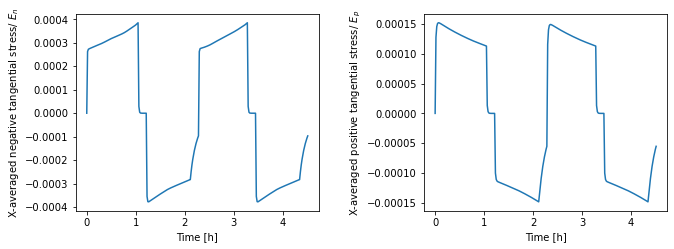

In [5]:
E_n = param["Negative electrode Young's modulus [Pa]"]
E_p = param["Positive electrode Young's modulus [Pa]"]

S_t_n_all = solution["X-averaged negative particle surface tangential stress [Pa]"].entries / E_n
S_t_p_all = solution["X-averaged positive particle surface tangential stress [Pa]"].entries / E_p
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, S_t_n_all, label="loss of active material model")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative tangential stress/ $E_n$")

ax2.plot(t_all, S_t_p_all, label="loss of active material model")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive tangential stress/ $E_p$")
f.tight_layout(pad=3.0)
plt.show()

In [6]:
k1 = 1e-4
k2 = 1e-3
k3 = 1e-2
param.update({"Positive electrode LAM constant proportional term [s-1]": k2/3600})
param.update({"Negative electrode LAM constant proportional term [s-1]": k2/3600})
sim2 = pybamm.Simulation(
    model, 
    experiment=experiment,
    parameter_values=param,
    solver=pybamm.CasadiSolver("fast with events"),
)
solution2 = sim2.solve(calc_esoh=False)
param.update({"Positive electrode LAM constant proportional term [s-1]": k3/3600})
param.update({"Negative electrode LAM constant proportional term [s-1]": k3/3600})
sim3 = pybamm.Simulation(
    model, 
    experiment=experiment,
    parameter_values=param,
    solver=pybamm.CasadiSolver("fast with events"),
)
solution3 = sim3.solve(calc_esoh=False)

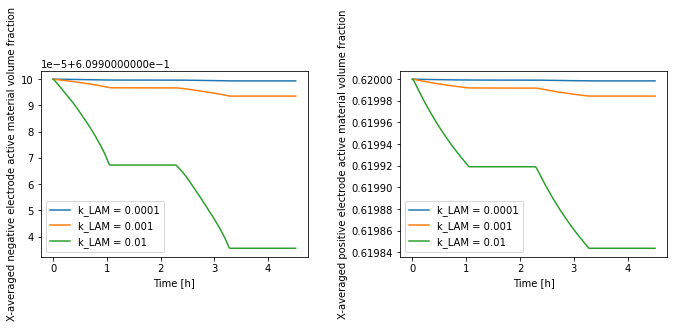

In [7]:

t_all2 = solution2["Time [h]"].entries
t_all3 = solution3["Time [h]"].entries
LAM_n_all2 = solution2["X-averaged negative electrode active material volume fraction"].entries
LAM_p_all2 = solution2["X-averaged positive electrode active material volume fraction"].entries
LAM_n_all3 = solution3["X-averaged negative electrode active material volume fraction"].entries
LAM_p_all3 = solution3["X-averaged positive electrode active material volume fraction"].entries

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, LAM_n_all, label="k_LAM = "+ str(k1))
ax1.plot(t_all2, LAM_n_all2, label="k_LAM = "+ str(k2))
ax1.plot(t_all3, LAM_n_all3, label="k_LAM = "+ str(k3))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative electrode active material volume fraction")
ax1.legend()
ax2.plot(t_all, LAM_p_all, label="k_LAM = "+ str(k1))
ax2.plot(t_all2, LAM_p_all2, label="k_LAM = "+ str(k2))
ax2.plot(t_all3, LAM_p_all3, label="k_LAM = "+ str(k3))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive electrode active material volume fraction")
f.tight_layout(pad=3.0)
ax2.legend()
plt.show()

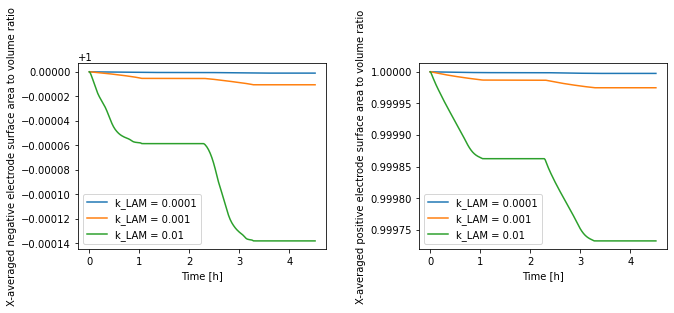

In [8]:
t_all2 = solution2["Time [h]"].entries
t_all3 = solution3["Time [h]"].entries
a_n_all = solution["X-averaged negative electrode surface area to volume ratio [m-1]"].entries
a_p_all = solution["X-averaged positive electrode surface area to volume ratio [m-1]"].entries
a_n_all2 = solution2["X-averaged negative electrode surface area to volume ratio [m-1]"].entries
a_p_all2 = solution2["X-averaged positive electrode surface area to volume ratio [m-1]"].entries
a_n_all3 = solution3["Negative electrode surface area to volume ratio [m-1]"].entries[-1,:]
a_p_all3 = solution3["Positive electrode surface area to volume ratio [m-1]"].entries[0,:]

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,4))
ax1.plot(t_all, a_n_all, label="k_LAM = "+ str(k1))
ax1.plot(t_all2, a_n_all2, label="k_LAM = "+ str(k2))
ax1.plot(t_all3, a_n_all3, label="k_LAM = "+ str(k3))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged negative electrode surface area to volume ratio [m-1]")
ax1.legend()
ax2.plot(t_all, a_p_all, label="k_LAM = "+ str(k1))
ax2.plot(t_all2, a_p_all2, label="k_LAM = "+ str(k2))
ax2.plot(t_all3, a_p_all3, label="k_LAM = "+ str(k3))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged positive electrode surface area to volume ratio [m-1]")
f.tight_layout(pad=3.0)
ax2.legend()
plt.show()

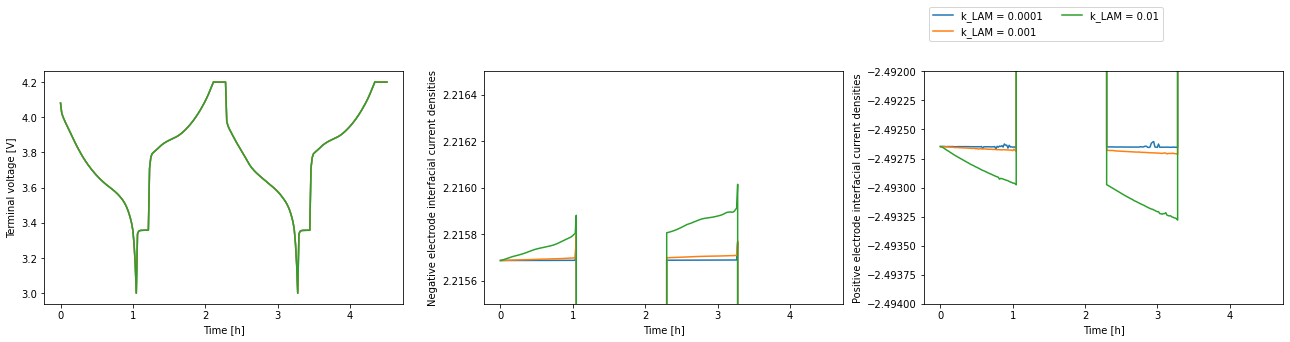

In [9]:

v_all = solution["Voltage [V]"].entries
v_all2 = solution2["Voltage [V]"].entries
v_all3 = solution3["Voltage [V]"].entries
I_if_n = solution["Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_p = solution["Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_n2 = solution2["Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_p2 = solution2["Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_n3 = solution3["Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]"].entries
I_if_p3 = solution3["Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]"].entries

f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(18,5))
ax1.plot(t_all, v_all, label="k_LAM = "+ str(k1))
ax1.plot(t_all2, v_all2, label="k_LAM = "+ str(k2))
ax1.plot(t_all3, v_all3, label="k_LAM = "+ str(k3))
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Voltage [V]")
#ax1.legend()
#ax1.set_xlim(0.5,0.8)

ax2.plot(t_all, I_if_n, label="k_LAM = "+ str(k1))
ax2.plot(t_all2, I_if_n2, label="k_LAM = "+ str(k2))
ax2.plot(t_all3, I_if_n3, label="k_LAM = "+ str(k3))
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Negative electrode interfacial current densities")
#ax2.legend()
#ax2.set_xlim(6000,7000)
ax2.set_ylim(2.2155,2.2165)

ax3.plot(t_all, I_if_p, label="k_LAM = "+ str(k1))
ax3.plot(t_all2, I_if_p2, label="k_LAM = "+ str(k2))
ax3.plot(t_all3, I_if_p3, label="k_LAM = "+ str(k3))
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Positive electrode interfacial current densities")
ax3.legend(bbox_to_anchor=(0.68, 1.3), ncol=2)
#ax3.set_xlim(2,2.8)
#ax3.set_ylim(2.492,2.494)
ax3.set_ylim(-2.494,-2.492)
plt.tight_layout(pad=1.0)


## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[5] Charles